In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/birds/src


## Initialization

### Imports

In [3]:
import re
import gc
import os
import time
import random
import operator
import datetime
import soundfile
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm
from scipy.special import softmax
from sklearn.model_selection import *

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.model_zoo as model_zoo

from torch import Tensor
from torch.optim import *
from audiomentations import *
from torch.nn.modules.loss import *
from torch.optim.lr_scheduler import * 
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader

In [4]:
from util import *
from params import *
from logger import create_logger

## Data

### Loading

In [5]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')

In [6]:
paths = []
for c, file in df_train[['ebird_code', 'filename']].values:
    path = f"{c}/{file[:-4]}.wav"
    paths.append(path)
    
df_train['file_path'] = paths

### Audio parameters

In [7]:
class AudioParams:
    sr = 32000
    duration = 5
    img_size = None

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = 16000
    
    n_fft = n_mels * 20 # Size of fft window - smooths the spectrogram
    
    spec_width = 256
    hop_length = duration * sr // spec_width + 1   # Computed to have width=spec_width

### Dataset

In [9]:
from data.dataset import BirdDataset

In [ ]:
dataset = BirdDataset(df_train, AudioParams, audio_path=AUDIO_PATH)

In [ ]:
x, y = dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


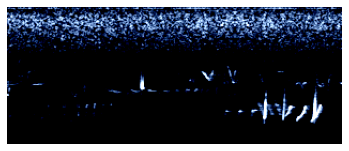

In [56]:
plt.imshow(x.transpose(1, 2, 0))
plt.axis(False)
plt.show()

In [12]:
x.shape

(3, 128, 313)

### Transforms

In [18]:
from data.transforms import get_wav_transforms

In [19]:
y, sr = soundfile.read(dataset.audio_path + dataset.paths[0])

In [20]:
ipd.Audio(y, rate=sr)

In [21]:
transforms = get_wav_transforms()

In [22]:
y_aug = transforms(samples=y, sample_rate=sr)

In [23]:
ipd.Audio(y_aug, rate=sr)

## Model

In [24]:
from model_zoo.models import get_model

In [25]:
model = get_model("resnet34", num_classes=NUM_CLASSES)

### Checkpoints

In [26]:
TODAY = str(datetime.date.today())
CP_TODAY = f'../checkpoints/{TODAY}/'

if not os.path.exists(CP_TODAY):
    os.mkdir(CP_TODAY)

# Training

In [27]:
from training.train import fit, predict

In [28]:
def train(config, df_train, df_val, fold):
    
    print(f'    -> {len(df_train)} training birds')
    print(f'    -> {len(df_val)} validation birds')
    
    seed_everything(config.seed)

    model = get_model(config.selected_model, num_classes=NUM_CLASSES).cuda()
    model.zero_grad()
    
    train_dataset = BirdDataset(df_train, AudioParams, audio_path=AUDIO_PATH)
    val_dataset = BirdDataset(df_val, AudioParams, audio_path=AUDIO_PATH, train=False)

    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    pred_val = fit(
        model, 
        train_dataset, 
        val_dataset, 
        epochs=config.epochs, 
        batch_size=config.batch_size, 
        val_bs=config.val_bs,
        lr=config.lr, 
        warmup_prop=config.warmup_prop,
        alpha=config.alpha,
        mixup_proba=config.mixup_proba,
        verbose_eval=config.verbose_eval,
    )

    if config.save:
        save_model_weights(model, f"{config.selected_model}_{config.name}_{fold}.pt", cp_folder=CP_TODAY)
    
    return pred_val

In [29]:
def k_fold(config, df):
    
    skf = StratifiedKFold(n_splits=config.k, random_state=config.random_state)
    splits = list(skf.split(X=df, y=df['ebird_code']))
    
    pred_oof = np.zeros((len(df), NUM_CLASSES))

    for i, (train_idx, val_idx) in enumerate(splits):
        if i in config.selected_folds:
            print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

            df_train = df.iloc[train_idx].copy()
            df_val = df.iloc[val_idx].copy()

            pred_val = train(config, df_train, df_val, i)
            pred_oof[val_idx] = pred_val
        
    return pred_oof

### Config

In [30]:
class Config:
    # General
    seed = 2020
    verbose = 1
    verbose_eval = 1
    save = True
    
    # k-fold
    k = 5
    random_state = 42
    selected_folds = [3, 4]
    
    # Model
    selected_model = 'resnest50_fast_1s1x64d'  
#     selected_model = 'resnet34'  
#     selected_model = 'efficientnet-b0'
    
#     img_size = 256
    batch_size = 64
    epochs = 50
    lr = 1e-3
    warmup_prop = 0.04
    val_bs = 64
    
    mixup_proba = 1
    alpha = 0.4
    
#     mixup_proba = 0.5
#     alpha = 5
    
    name = "mixup4"

### Training

In [ ]:
pred_oof = k_fold(Config, df_train)


-------------   Fold 4 / 5  -------------

    -> 17100 training birds
    -> 4275 validation birds
    -> 24709832 trainable parameters

